In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve, nsolve

In [21]:
from matplotlib.colors import LogNorm
from matplotlib import rcParams

Define symbols for two codon model

In [22]:
Tt1, Tt2, Tc1, Tc2, Rb1, Rb2, fopt = symbols('Tt1 Tt2 Tc1 Tc2 Rb1 Rb2 fopt')
Rt, Rb, Tt, Tc, N, L, Ksp, Kbd, Kch = symbols('Rt Rb Tt Tc N L Ksp Kbd Kch')

Define equilibrium equations for two codon model

In [23]:
eq1 = Eq((Rt-Rb1-Rb2)*Kbd*N, (Tc1*Rb1+Tc2*Rb2)*Ksp*(1/L)) 
eq2 = Eq(Tc1*Rb1*(1-fopt), Tc2*Rb2*fopt)

In [24]:
eq3 = Eq((Tt1-Tc1)*Kch, Tc1*Rb1*Ksp)
eq4 = Eq((Tt2-Tc2)*Kch, Tc2*Rb2*Ksp)

In [110]:
# this function is identical to wrapper.solve_numeric except it allows for sweeps over multiple sets of initial conditions
# only ended up using it for this analysis, so I didn't bother refactoring it and moving it into the wrapper module

from copy import copy

def param_sweep_multi(fixed_params, 
                targets, 
                vals,
                names,
                _vals = None, 
                time=100, 
                fop_max=100,
                interval=1,
                verbose=True,
                solver="mnewton",
                guess=[15,15,15,15]):
    """
    Solve numerically for Rb1, Tc1, Rb2, and Tc2 using an mnewton solver.
    
    params:
        fix_params: model parameters with fixed values
        target: model parameter to vary (a sympy Symbol object)
        vals: values for the target parameter
        _vals: optional, list of transformed target values
        name: name to use for the target parameter
        time: corresponds to seconds of simulation time
    """
    fopts = [x/100 for x in range(0, fop_max+1, interval)]
    df = None
    for i in range(len(vals[0])):
        for j in range(len(vals)):
            params[targets[j]] = vals[j][i]
        if verbose:
            print(params)
        solutions = []
        xvals = []
        for f in fopts:
            cp = copy(params)
            cp[fopt] = f
            Eq1 = eq1.evalf(subs=cp)
            Eq2 = eq2.evalf(subs=cp)
            Eq3 = eq3.evalf(subs=cp)
            Eq4 = eq4.evalf(subs=cp)
            for guess in range(10, 100):
                try:
                    solution = nsolve([Eq1, Eq2, Eq3, Eq4], 
                                      [Rb1, Rb2, Tc1, Tc2], 
                                      [guess, guess, guess, guess], 
                                      dict=True, 
                                      solver=solver)
                except Exception:
                    pass
                else:
                    solutions.append(solution)
                    xvals.append(f)
                    break
        rb1 = [float(x[0][Rb1]) for x in solutions]
        rb2 = [float(x[0][Rb2]) for x in solutions]
        tc1 = [float(x[0][Tc1]) for x in solutions]
        tc2 = [float(x[0][Tc2]) for x in solutions]
        tmp = pd.DataFrame({"fopt": xvals,
                             "rb1": rb1,
                             "rb2": rb2,
                             "tc1": tc1,
                             "tc2": tc2})
        for idx, name in enumerate(names):
            tmp[name] = vals[idx][i]
        tmp["tu1"] = float(params[Tt1]) - tmp["tc1"]
        tmp["tu2"] = float(params[Tt2]) - tmp["tc2"]
        # formula for calculating total protein from Tu1
        tmp["protein"] = (time*float(params[Kch])*tmp["tu1"]) / (tmp["fopt"] * float(params[L]))
        tmp["Rb"] = tmp["rb1"] + tmp["rb2"]
        tmp["Tc"] = tmp["tc1"] + tmp["tc2"]
        
        if _vals:
            tmp[f'{name}_'] = _vals[idx]
        if df is not None:
            df = df.append(tmp, ignore_index=True)
        else:
            df = tmp
    
    return df

Here we'll scale simulations according to the tRNA scaling relationship ("Scaling law" section of manuscript)

In [111]:
# total tRNAs of 2500, 25000, and 250000
# values scaled such that changing the tRNA abundance doesn't shift the curve

params = {N: 100,
       Kbd: 0.005,
#       Kch: 30,
       Rt: 500,
#       Tt1: 1750,
#       Tt2: 750,
#       Ksp: 0.05,
       L: 300}

trna1 = [175, 1750, 17500]
trna2 = [75, 750, 7500]
k_ch = [300, 30, 3]
k_sp = [0.5, 0.05, 0.005]
df_07_tscale_05 = param_sweep_multi(params, 
                                  [Tt1, Tt2, Kch, Ksp], 
                                  [trna1, trna2, k_ch, k_sp], 
                                  ["Tt1", "Tt2", "kch", "ksp"],
                                   interval=5,
                                   guess=[20,20,20,20]) 

trna1 = [175, 1750, 17500]
trna2 = [75, 750, 7500]
k_ch = [300, 30, 3]
k_sp = [5, 0.5, 0.05]
df_07_tscale_5 = param_sweep_multi(params, 
                                  [Tt1, Tt2, Kch, Ksp], 
                                  [trna1, trna2, k_ch, k_sp], 
                                  ["Tt1", "Tt2", "kch", "ksp"],
                                   interval=5,
                                  guess=[14.5,14.5,14.5,14.5])

trna1 = [175, 1750, 17500]
trna2 = [75, 750, 7500]
k_ch = [300, 30, 3]
k_sp = [0.05, 0.005, 0.0005]
df_07_tscale_005 = param_sweep_multi(params, 
                                  [Tt1, Tt2, Kch, Ksp], 
                                  [trna1, trna2, k_ch, k_sp], 
                                  ["Tt1", "Tt2", "kch", "ksp"],
                                   interval=5,
                                   guess=[20,20,20,20]) 

{N: 100, Kbd: 0.005, Rt: 500, L: 300, Tt1: 175, Tt2: 75, Kch: 300, Ksp: 0.5}
{N: 100, Kbd: 0.005, Rt: 500, L: 300, Tt1: 1750, Tt2: 750, Kch: 30, Ksp: 0.05}
{N: 100, Kbd: 0.005, Rt: 500, L: 300, Tt1: 17500, Tt2: 7500, Kch: 3, Ksp: 0.005}
{N: 100, Kbd: 0.005, Rt: 500, L: 300, Tt1: 175, Tt2: 75, Kch: 300, Ksp: 5}
{N: 100, Kbd: 0.005, Rt: 500, L: 300, Tt1: 1750, Tt2: 750, Kch: 30, Ksp: 0.5}
{N: 100, Kbd: 0.005, Rt: 500, L: 300, Tt1: 17500, Tt2: 7500, Kch: 3, Ksp: 0.05}
{N: 100, Kbd: 0.005, Rt: 500, L: 300, Tt1: 175, Tt2: 75, Kch: 300, Ksp: 0.05}
{N: 100, Kbd: 0.005, Rt: 500, L: 300, Tt1: 1750, Tt2: 750, Kch: 30, Ksp: 0.005}
{N: 100, Kbd: 0.005, Rt: 500, L: 300, Tt1: 17500, Tt2: 7500, Kch: 3, Ksp: 0.0005}


In [112]:
df_07_tscale_05["kspeed_factor"] = 1
df_07_tscale_5["kspeed_factor"] = 10
df_07_tscale_005["kspeed_factor"] = 0.1

df_07_trna_scaling = pd.concat([df_07_tscale_05, df_07_tscale_5, df_07_tscale_005]).reset_index()

In [113]:
norm1 = LogNorm(vmin=0.1, vmax=10) 

df_07_trna_scaling["protein_expr_rate"] = df_07_trna_scaling["protein"] / 100

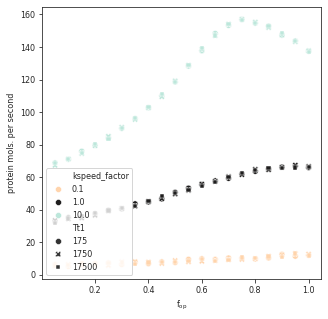

In [114]:
#fig, ax = plt.subplots(1, 2) #figsize=(24, 6)

plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams["text.usetex"] = False
#plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "8"
plt.rcParams["mathtext.default"] = "regular"

sns.set_style("ticks")

palette = sns.color_palette("icefire_r", as_cmap=True)

import numpy as np
def jitter(arr, amount=1):
    return arr + np.random.uniform(-amount, amount, size=len(arr))

g1 = sns.scatterplot(data=df_07_trna_scaling, 
                 x="fopt", 
                 y=jitter(df_07_trna_scaling["protein_expr_rate"]), 
                 style="Tt1",
                 #style="Tt1",
                 hue="kspeed_factor",
                 hue_norm=norm1,
                 palette=palette,
                 #linewidth=4
                    )   
g1.set_xlabel(r"$f_{op}$")
#g1.set_ylim(0, 110)
g1.set_ylabel("protein mols. per second")
#g1.set_title("total tRNAs = 2500")
g1.legend(loc="lower left")
#g1.axvline(0.7, alpha=0.3, color="grey")

Above figure shows that we can increase the total number of tRNAs without changing the protein expression rate, as long as we divide kcharge and kspeed by the scaling factor. We do this for three different sets of simulations with different baseline initial conditions so three different curves are produced.

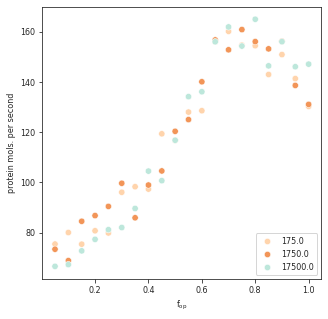

In [119]:
#fig, ax = plt.subplots(1, 2) #figsize=(24, 6)

plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams["text.usetex"] = False
#plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "8"
plt.rcParams["mathtext.default"] = "regular"

sns.set_style("ticks")

palette = sns.color_palette("icefire_r", as_cmap=True)

import numpy as np
def jitter(arr, amount=10):
    return arr + np.random.uniform(-amount, amount, size=len(arr))

g1 = sns.scatterplot(data=df_07_trna_scaling[(df_07_trna_scaling.kspeed_factor==10)], 
                 x="fopt", 
                 s=40,
                 y=jitter(df_07_trna_scaling["protein_expr_rate"]),
                 #y="protein_expr_rate",
                 #style="Tt1",
                 hue="Tt1",
                 palette=palette,
                 #linewidth=4
                    )   
g1.set_xlabel(r"$f_{op}$")
#g1.set_ylim(0, 110)
g1.set_ylabel("protein mols. per second")
#g1.set_title("total tRNAs = 2500")
g1.legend(loc="lower right")
#g1.axvline(0.7, alpha=0.3, color="grey")

In [13]:
# total ribosomes of 50, 500, 5000
# Kbd scaled by 0.1, 1, 10, 100 (relative to baseline model)
# values are also scaled such that changing the ribosome abundance doesn't shift the curve

params = {N: 100,
#       Kbd: 0.005,
       Kch: 30,
#       Rt: 500,
       Tt1: 1750,
       Tt2: 750,
#       Ksp: 0.05,
       L: 300}


rib = [50, 500, 5000]
k_bd = [0.005, 0.0005, 0.00005]
k_sp = [0.5, 0.05, 0.005]
df_07_rscale_0005 = param_sweep_multi(params, 
                                  [Rt, Kbd, Ksp], 
                                  [rib, k_bd, k_sp], 
                                  ["Rib", "kbd", "ksp"],
                                   interval=5) 

# has the same parameter scales as the baseline model
rib = [50, 500, 5000]
k_bd = [0.05, 0.005, 0.0005]
k_sp = [0.5, 0.05, 0.005]
df_07_rscale_005 = param_sweep_multi(params, 
                                  [Rt, Kbd, Ksp], 
                                  [rib, k_bd, k_sp], 
                                  ["Rib", "kbd", "ksp"],
                                   interval=5) 

rib = [50, 500, 5000]
k_bd = [0.5, 0.05, 0.005]
k_sp = [0.5, 0.05, 0.005]
df_07_rscale_05 = param_sweep_multi(params, 
                                  [Rt, Kbd, Ksp], 
                                  [rib, k_bd, k_sp], 
                                  ["Rib", "kbd", "ksp"],
                                   interval=5)

rib = [50, 500, 5000]
k_bd = [5, 0.5, 0.05]
k_sp = [0.5, 0.05, 0.005]
df_07_rscale_5 = param_sweep_multi(params, 
                                  [Rt, Kbd, Ksp], 
                                  [rib, k_bd, k_sp], 
                                  ["Rib", "kbd", "ksp"],
                                   interval=5)

{N: 100, Kch: 30, Tt1: 1750, Tt2: 750, L: 300, Rt: 50, Kbd: 0.005, Ksp: 0.5}
{N: 100, Kch: 30, Tt1: 1750, Tt2: 750, L: 300, Rt: 500, Kbd: 0.0005, Ksp: 0.05}
{N: 100, Kch: 30, Tt1: 1750, Tt2: 750, L: 300, Rt: 5000, Kbd: 5e-05, Ksp: 0.005}
{N: 100, Kch: 30, Tt1: 1750, Tt2: 750, L: 300, Rt: 50, Kbd: 0.05, Ksp: 0.5}
{N: 100, Kch: 30, Tt1: 1750, Tt2: 750, L: 300, Rt: 500, Kbd: 0.005, Ksp: 0.05}
{N: 100, Kch: 30, Tt1: 1750, Tt2: 750, L: 300, Rt: 5000, Kbd: 0.0005, Ksp: 0.005}
{N: 100, Kch: 30, Tt1: 1750, Tt2: 750, L: 300, Rt: 50, Kbd: 0.5, Ksp: 0.5}
{N: 100, Kch: 30, Tt1: 1750, Tt2: 750, L: 300, Rt: 500, Kbd: 0.05, Ksp: 0.05}
{N: 100, Kch: 30, Tt1: 1750, Tt2: 750, L: 300, Rt: 5000, Kbd: 0.005, Ksp: 0.005}
{N: 100, Kch: 30, Tt1: 1750, Tt2: 750, L: 300, Rt: 50, Kbd: 5, Ksp: 0.5}
{N: 100, Kch: 30, Tt1: 1750, Tt2: 750, L: 300, Rt: 500, Kbd: 0.5, Ksp: 0.05}
{N: 100, Kch: 30, Tt1: 1750, Tt2: 750, L: 300, Rt: 5000, Kbd: 0.05, Ksp: 0.005}


In [14]:
df_07_rscale_0005["kbd_factor"] = 0.1
df_07_rscale_005["kbd_factor"] = 1
df_07_rscale_05["kbd_factor"] = 10
df_07_rscale_5["kbd_factor"] = 100

df_07_ribosome_scaling = pd.concat([df_07_rscale_0005, df_07_rscale_005, df_07_rscale_05, df_07_rscale_5]).reset_index()

In [15]:
norm1 = LogNorm(vmin=0.1, vmax=100) 

df_07_ribosome_scaling["protein_expr_rate"] = df_07_ribosome_scaling["protein"] / 100

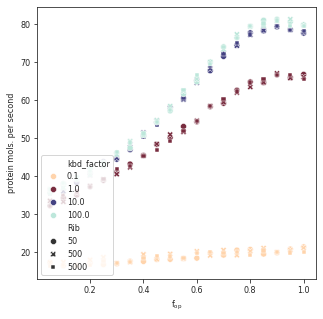

In [ ]:
#fig, ax = plt.subplots(1, 2) #figsize=(24, 6)

plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams["text.usetex"] = False
#plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "8"
plt.rcParams["mathtext.default"] = "regular"

sns.set_style("ticks")

palette = sns.color_palette("icefire_r", as_cmap=True)

import numpy as np
def jitter(arr, amount=1):
    return arr + np.random.uniform(-amount, amount, size=len(arr))

g1 = sns.scatterplot(data=df_07_ribosome_scaling, 
                 x="fopt", 
                 y=jitter(df_07_ribosome_scaling["protein_expr_rate"]), 
                 style="Rib",
                 #style="Tt1",
                 hue="kbd_factor",
                 hue_norm=norm1,
                 palette=palette,
                 #linewidth=4
                    )   
g1.set_xlabel(r"$f_{op}$")
#g1.set_ylim(0, 110)
g1.set_ylabel("protein mols. per second")
#g1.set_title("total tRNAs = 2500")
g1.legend(loc="lower left")
#g1.axvline(0.7, alpha=0.3, color="grey")

Above figure shows that we can also do this with total ribosome content

In [120]:
df_07_trna_scaling.to_csv("parameter_scaling_trna_kspeed.csv")

In [19]:
df_07_ribosome_scaling.to_csv("parameter_scaling_ribosome_kbind.csv")